# Try batch normalization

### BatchNorm

Batch normalization を加えてみる.

* Fully connected なら 各ノードの入力を正規化する.
* CNN なら channel 毎に空間２次元について統計をとる.

https://pytorch.org/docs/stable/nn.html#batchnorm2d

```
torch.nn.BatchNorm2d(num_features)
```

`num_features` には channel の数を入れておけばいい.

### ReLU の前・後？

前らしい


### bias は？

bias が消されてしまうのでは？ 原論文では Wx に batch normalization を施した後に bias b を足す. 

PyTorch などのライブラリでは:

$$
y = \frac{X - \mathrm{E}[X]}{\sqrt{\mathrm{Var}[X] + \epsilon}} \gamma + \beta
$$

つまり、元の bias は役立たずになるが、batch normaliztion が新たな（学習する）パラメタ $\gamma$ と $\beta$ を持っている (`affine=True`).



### momentum

統計量（平均・分散）は moving average で行われている。`momentum` はそのパラメタ (`track_running_stats=True`)。


### eval 時

推論モード `eval()` では E[X]  と Var[Z] は固定される. 学習時の最後の値？



### ReLU と max pool

MaxPool・ReLU = ReLU・MaxPool なので先に MaxPool した方がちょっと計算量を減らせる. ReLU に限らず、単調増大な activication function なら成り立つ.




In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F  # F.relu とか

print('PyTorch version', torch.__version__)


# GPU が使えるなら使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

if torch.cuda.is_available():
  print('GPU:', torch.cuda.get_device_name(0))

PyTorch version 1.1.0
Device: cuda:0
GPU: Tesla T4


In [5]:
# データが PIL.Image なので、torch.Tensor に変換する
to_tensor = torchvision.transforms.ToTensor()

train = torchvision.datasets.MNIST(root='./input', train=True,
                                   download=True, transform=to_tensor)
test = torchvision.datasets.MNIST(root='./input', train=False,
                                  transform=to_tensor)
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./input
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./input
    Split: Test


In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [0]:
class NormNet(nn.Module):
    def __init__(self):
        # ここでは各レイヤーを定義しているだけ。繋がっていない
        # Sequential を使って __init__ 時点でつなぐ流儀もある
        super(NormNet, self).__init__()
        self.conv1a = nn.Conv2d(1,  16, 3)  # 28x28x1  -> 26x26x16
        self.conv1b = nn.Conv2d(16, 16, 3)  # 26x26x16 -> 24x24x16
        self.norm1  = nn.BatchNorm2d(16)
        self.pool1  = nn.MaxPool2d(2, 2)    # 24x24x16 -> 12x12x16
        
        self.conv2a = nn.Conv2d(16, 32, 3)  # 12x12x16 -> 10x10x32
        self.conv2b = nn.Conv2d(32, 32, 3)  # 10x10x32 -> 8x8x32
        self.norm2  = nn.BatchNorm2d(32)
        self.pool2  = nn.MaxPool2d(2, 2)    # 8x8x32 -> 4x4x32
        self.fc1    = nn.Linear(4 * 4 * 32, 50)  # fully connected -> 50
        self.dropout1 = nn.Dropout2d()           # default dropout rate is 0.5
        self.fc2      = nn.Linear(50, 10)        # 50 -> 10 number of classes
        #self.dropout2 = nn.Dropout2d()

    def forward(self, x):
        # レイヤーをつなげている
        x = F.relu(self.conv1a(x))
        x = self.norm1(self.conv1b(x))  # Adding batch normalization
        x = F.relu(self.pool1(x))
        
        x = F.relu(self.conv2a(x))
        x = self.norm2(self.conv2b(x))
        x = F.relu(self.pool2(x))

        x = x.view(-1, 4 * 4 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.fc2(x)
        #x = self.dropout2(x)

        return x

In [16]:
# Model と 最適化方法
model = NormNet()
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)  # send to GPU if available

# 訓練の進行具合を記録
def measure_scores(name, loader, history, *, nbatch=100):
    loss_sum = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader, 0):
            # send data to GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = cross_entropy(outputs, labels)
            loss_sum += loss
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i + 1 == nbatch:
              break

    # average loss during the epoch
    loss_average = loss_sum / len(train_loader)
    accuracy = correct/total
    
    history[name + '_loss'].append(loss_average)
    history[name + '_accuracy'].append(accuracy)
            
            
epochs = 20
history = {'train_loss': [], 'test_loss': [],
           'train_accuracy': [], 'test_accuracy': []}
times_train = []
times_test = []

for iepoch in range(epochs):
    model.train()  # 訓練モード
    time_train = 0.0
    for i, (images, labels) in enumerate(train_loader, 0): 
        ts = time.time()
        
        # send data to GPU
        images = images.to(device)
        labels = labels.to(device)
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        te = time.time()
        time_train += (te - ts)
    
    times_train.append(time_train)
    
    # Measure test accuracy for each epoch
    ts = time.time()
    
    model.eval()  # evaluation モード; dropout しないなど
    
    measure_scores('train', train_loader, history)    
    measure_scores('test', test_loader, history)
    
    
    te = time.time()
    times_test.append(te - ts)
    
    print('Epoch %d: loss %.4e %.4e, Test accuracy %.6f' % (iepoch + 1,
          history['train_loss'][-1],
          history['test_loss'][-1],
          history['test_accuracy'][-1]))

    
print('Finished Training')
print('Training %.2f ± %.2f sec per epoch' % (np.mean(times_train), np.std(times_train)))
print('Test evaluation %.4f ± %.4f sec per epoch' % (np.mean(times_test), np.std(times_test)))
print('Total %.2f sec' % (np.sum(times_test) + np.sum(times_test)))

Epoch 1: loss 8.2117e-03 7.3979e-03, Test accuracy 0.985700
Epoch 2: loss 5.0034e-03 4.7916e-03, Test accuracy 0.990600
Epoch 3: loss 6.2416e-03 6.8877e-03, Test accuracy 0.986600
Epoch 4: loss 3.3580e-03 4.1632e-03, Test accuracy 0.991600
Epoch 5: loss 2.6394e-03 3.8991e-03, Test accuracy 0.992600
Epoch 6: loss 2.9853e-03 3.7700e-03, Test accuracy 0.992600
Epoch 7: loss 3.2796e-03 3.7750e-03, Test accuracy 0.993400
Epoch 8: loss 1.7224e-03 3.4862e-03, Test accuracy 0.994200
Epoch 9: loss 2.2922e-03 4.3474e-03, Test accuracy 0.992900
Epoch 10: loss 1.7363e-03 3.5138e-03, Test accuracy 0.993500
Epoch 11: loss 2.1384e-03 3.6469e-03, Test accuracy 0.993300
Epoch 12: loss 1.9831e-03 4.2876e-03, Test accuracy 0.993500
Epoch 13: loss 8.9733e-04 3.2563e-03, Test accuracy 0.993700
Epoch 14: loss 6.5818e-04 3.6425e-03, Test accuracy 0.993800
Epoch 15: loss 1.3475e-03 4.0888e-03, Test accuracy 0.992900
Epoch 16: loss 9.5833e-04 3.6069e-03, Test accuracy 0.993400
Epoch 17: loss 1.2136e-03 3.9345e

* 学習が早くなった 😀 Epoch 4 にして 99% を超えている


* 過学習を防止するというのは本当？理屈がわからないけど.

  - 最後の dropout をなくしてみる → うーん... Test accuracy は 99.3% で安定していて loss は上がっていない. しかし train - test 格差は発生してる. ちょっと怪しい. まあ、その辺りは実際の応用毎に確認するということで.




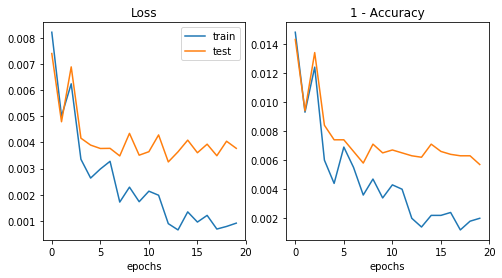

In [17]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('epochs')
plt.plot(history['train_loss'], label='train')
plt.plot(history['test_loss'], label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('1 - Accuracy')
plt.xlabel('epochs')
plt.plot(1 - np.array(history['train_accuracy']))
plt.plot(1 - np.array(history['test_accuracy']))
plt.show()

## 参考

Example on how to use batch-norm?

https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216